### Sources Used  
[Nueral networks theoretical explanation by 3Blue1Brown](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)  
[Canvas artifical neural network - How to apply](https://fhict.instructure.com/courses/13413/pages/ann-how-to-apply?module_item_id=993448)  
[Determining ANN layers and neurons](https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3#:~:text=Number%20of%20Neurons%20and%20Number%20of%20Layers%20in%20Hidden%20Layer&text=The%20number%20of%20hidden%20neurons,size%20of%20the%20output%20layer.)   
[Tensor flow image classification documentation](https://www.tensorflow.org/tutorials/images/classification)  
[Binding Of Isaac item dataset](https://www.kaggle.com/datasets/heidaran/binding-of-isaac-item-dataset?resource=download)

### Introduction
The Binding of Isaac is a single player rouge like game with over 700 unique collectible items, in this notebook ANN models from tensorflow keras will be explored to create an image classification model that can identify the unique items based on an image.

A classification model should work fairly well for this dataset, as the images it will have to classify are all generally the same, as the game is 2D with very static lighting, allowing for most instances of the items within an image to look very similar on a pixel basis.

The dataset used contains 200 artificially transformed images with the base images being extracted directly from the game files.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Set dataset values

In [2]:
dataset_directory = 'collectible-icons'
img_height = 32
img_width = 32

Load the dataset from directory, this should be 200 instances of 719 classes (719 items) according to the [BOI wiki in repentance V1.7.5](https://bindingofisaacrebirth.fandom.com/wiki/Items)

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(dataset_directory, labels='inferred', seed=123)

Found 143800 files belonging to 719 classes.


Check an example sample of the dataset images, to get a better idea of the images we are working with

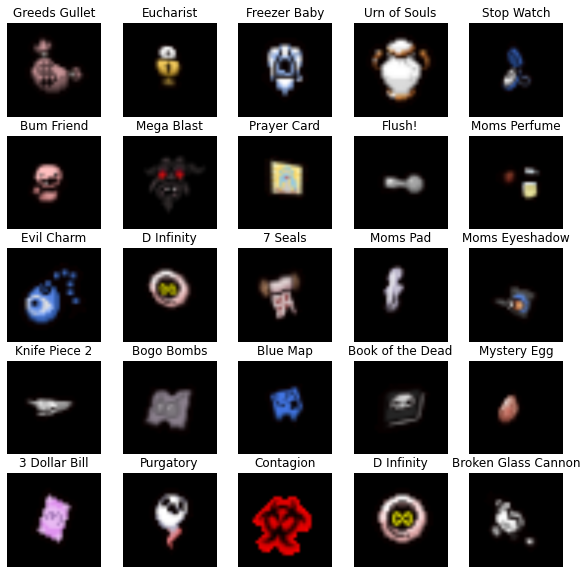

In [4]:
plt.figure(figsize=(10, 10))
class_names = dataset.class_names
for images, labels in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Create the actual train and test datasets, these will have a 4:1 split of train:test
Ensure that the same seed is used, as otherwise the dataset will be shuffled between splits, and some images might be excluded in duplicated

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

Found 143800 files belonging to 719 classes.
Using 115040 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))

Found 143800 files belonging to 719 classes.
Using 28760 files for validation.


Cache the datasets to reduce disk operation load (otherwise tensor flow might block the files while using the dataset, as it is still reading from the source files)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Compile the first model  
This model Performs a rescaling operation to convert the 3 RGB values into a range of 0-1, as this should improve model performance
(This approach is slightly more efficient than applying the layer on the data itself, due to some internal conversions tensor flow will make to the data beforehand)

This model contains 4 layers, with 2 hidden layers as follows
```
(Pixel RGB values)                      (Flattened layer from R, G, B to single value)
| ⎴  |              | ⎴  |              | ⎴  |                | ⎴  |
| •  |              | •  |              | •  |                | •  |
| •  |              | •  |              | •  |                | •  |
|1024|x3     ->     | 16 |x3     ->     | 32 |       ->       |719 |
| •  |              | •  |              | •  |                | •  |
| •  |              | •  |              | •  |                | •  |
| ⎵  |              | ⎵  |              | ⎵  |                | ⎵  |
             (Specified neuron layer for R, G, B value)       (Classification layer for each class)
```

In [8]:
num_classes = len(class_names)

base_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

base_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Perform 4 iterations of the model, it can be observed that the first epoch takes significantly longer, this is due to the model not actually initializing during the compile stage but lazy loading it only when necessary (as soon as the first epoch of the fitting process starts)

In [9]:
epochs=4
history = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4


3595/3595 [==============================] - 132s 29ms/step - loss: 2.2837 - accuracy: 0.5029 - val_loss: 1.1010 - val_accuracy: 0.7208
Epoch 2/4
3595/3595 [==============================] - 28s 8ms/step - loss: 0.7938 - accuracy: 0.7956 - val_loss: 0.5893 - val_accuracy: 0.8403
Epoch 3/4
3595/3595 [==============================] - 25s 7ms/step - loss: 0.4482 - accuracy: 0.8795 - val_loss: 0.3487 - val_accuracy: 0.9070
Epoch 4/4
3595/3595 [==============================] - 26s 7ms/step - loss: 0.2947 - accuracy: 0.9189 - val_loss: 0.2608 - val_accuracy: 0.9312


Graph the accuracy and loss (cost) of the train and validation data across the iterations

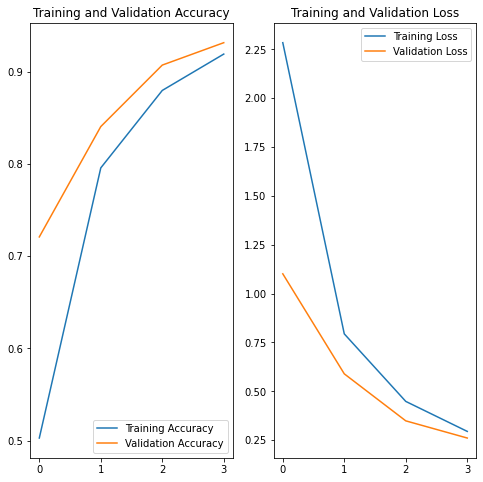

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The results are actually extremely promising, with somehow the validation data performing even better than the training data

Let's test the model out on a new image taken from the game

In [65]:
def Predict(model, imagePath, class_names):
    img = tf.keras.utils.load_img(
    imagePath, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [18]:
Predict(base_model, "ann_image_test_chocolate_milk.png", class_names)

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to Experimental Treatment with a 79.66 percent confidence.


when giving it an image of the "chocolate milk" item, it thinks that it is an experimental treatment...
They, don't even have the same colors. Which is even more suprising when considering that the first layers account for this by splitting the R, G and B values

(-0.5, 31.5, 31.5, -0.5)

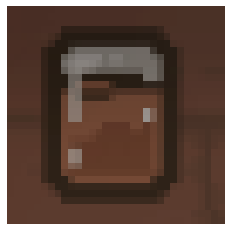

In [14]:
img = np.asarray(Image.open('ann_image_test_chocolate_milk.png'))
plt.imshow(img)
plt.axis("off")

(-0.5, 31.5, 31.5, -0.5)

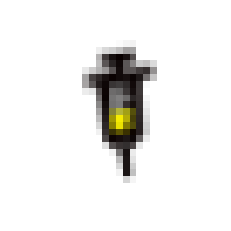

In [15]:
img = np.asarray(Image.open('collectible-icons/Experimental Treatment/Experimental Treatment_1.png'))
plt.imshow(img)
plt.axis("off")

Lets see if the model is overfitted then, by supplying it with an image of the chocolate milk item that exists within the dataset

In [19]:
Predict(base_model, "collectible-icons/Chocolate Milk/Chocolate Milk_1.png", class_names)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to Chocolate Milk with a 99.91 percent confidence.


When using an image from the dataset itself it is very confident that it indeed is Chocolate Milk, this very heavily indicates overfitting

In [20]:
Predict(base_model, "ann_image_test_chocolate_milk_transparent.png", class_names)

1/1 [==============================] - 0s 16ms/step
This image most likely belongs to Crickets Head with a 73.84 percent confidence.


In [21]:
Predict(base_model, "ann_image_test_scorpio.png", class_names)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to The Negative with a 36.80 percent confidence.


Here, I once again tried the prediction with the new chocolate milk image, this time however, I removed the background as the dataset images also did not have any background, but this still resulted in an incorrect prediction.  
To verify that it is not just extremely bad luck I attempted the prediction with another new item called "scorpio", as getting two wrong with a supposed 93% accuracy with 700+ classes would be extemely unlikely

Within the tensorflow documentation two methods of fighting overfitting are explained, one with data augmentation by transforming the image which is already done in this database, and model dropout which will be explored below

In [22]:
num_classes = len(class_names)

dropout_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

dropout_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
epochs=4
history = dropout_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4
3595/3595 [==============================] - 30s 8ms/step - loss: 2.2384 - accuracy: 0.5139 - val_loss: 0.9064 - val_accuracy: 0.7702
Epoch 2/4
3595/3595 [==============================] - 29s 8ms/step - loss: 0.7496 - accuracy: 0.8020 - val_loss: 0.5232 - val_accuracy: 0.8592
Epoch 3/4
3595/3595 [==============================] - 28s 8ms/step - loss: 0.4694 - accuracy: 0.8696 - val_loss: 0.3272 - val_accuracy: 0.9156
Epoch 4/4
3595/3595 [==============================] - 28s 8ms/step - loss: 0.3445 - accuracy: 0.9028 - val_loss: 0.2709 - val_accuracy: 0.9251


In [27]:
Predict(dropout_model, "ann_image_test_chocolate_milk_transparent.png", class_names)

1/1 [==============================] - 0s 16ms/step
This image most likely belongs to The Bible with a 93.25 percent confidence.


This sadly also did not work, with it seemingly only decreasing the performance of the model, which would be correct when considering that dropout attempts to sabotage some nodes to force the model rely on different paths

The issue could also be that the model does not have enough neurons in its layers to be able to properly differentiate between the classes, as there are 700+ classes which get confined to 32 neurons before having to predict the class

In [39]:
num_classes = len(class_names)

large_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(320, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(640, activation='relu'),
  layers.Dense(num_classes)
])

large_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=2
history = large_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/2
3595/3595 [==============================] - 1678s 467ms/step - loss: 0.7804 - accuracy: 0.8324 - val_loss: 0.1492 - val_accuracy: 0.9604
Epoch 2/2
3595/3595 [==============================] - 1651s 459ms/step - loss: 0.1015 - accuracy: 0.9723 - val_loss: 0.1306 - val_accuracy: 0.9630


In [44]:
Predict(large_model, "ann_image_test_chocolate_milk_transparent.png", class_names)

1/1 [==============================] - 0s 30ms/step
This image most likely belongs to The Bible with a 94.83 percent confidence.


Even with the much larger model (more nodes per layer), it still does not predict the correct classification, as it now thinks the chocolate milk (with transparent background) is a bible...
However, this could now also be due to the limited (2) epochs performed, as these iterations take significantly longer

Lastly, lets test the model on a much smaller dataset, in this dataset I will only include 10 different items, to see if it might still be the neuron count, without having to spend hours fitting a model (as the attempt above already took 30 minutes per epoch)

In [61]:
subset_dataset_directory = "collectible-icons-subset"

train_sub_ds = tf.keras.utils.image_dataset_from_directory(
  subset_dataset_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

val_sub_ds = tf.keras.utils.image_dataset_from_directory(
  subset_dataset_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))

sub_class_names = train_sub_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

train_sub_ds = train_sub_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_sub_ds = val_sub_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 10 classes.
Using 1600 files for training.
Found 2000 files belonging to 10 classes.
Using 400 files for validation.


In [122]:
num_sub_classes = len(sub_class_names)

sub_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_sub_classes)
])

sub_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history = sub_model.fit(
  train_sub_ds,
  validation_data=val_sub_ds,
  epochs=epochs
)

Epoch 1/10
50/50 [==============================] - 1s 9ms/step - loss: 1.7215 - accuracy: 0.5075 - val_loss: 1.1117 - val_accuracy: 0.7425
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.6700 - accuracy: 0.8425 - val_loss: 0.4881 - val_accuracy: 0.8825
Epoch 3/10
50/50 [==============================] - 0s 7ms/step - loss: 0.3334 - accuracy: 0.9325 - val_loss: 0.3120 - val_accuracy: 0.9100
Epoch 4/10
50/50 [==============================] - 0s 7ms/step - loss: 0.2196 - accuracy: 0.9513 - val_loss: 0.2141 - val_accuracy: 0.9400
Epoch 5/10
50/50 [==============================] - 0s 7ms/step - loss: 0.1588 - accuracy: 0.9681 - val_loss: 0.2077 - val_accuracy: 0.9325
Epoch 6/10
50/50 [==============================] - 0s 7ms/step - loss: 0.1221 - accuracy: 0.9775 - val_loss: 0.1649 - val_accuracy: 0.9550
Epoch 7/10
50/50 [==============================] - 0s 7ms/step - loss: 0.0991 - accuracy: 0.9812 - val_loss: 0.1443 - val_accuracy: 0.9600
Epoch 8/10
50/50 [==

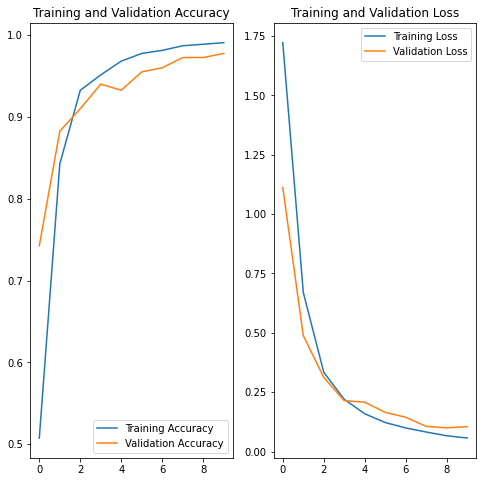

In [123]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [124]:
Predict(sub_model, "ann_image_test_chocolate_milk_transparent.png", sub_class_names)

1/1 [==============================] - 0s 43ms/step
This image most likely belongs to Scorpio with a 98.86 percent confidence.


Above, I have messed around with the neuron count, the dataset amount, different epochs, etc. But the model is still incorrect in reality while the statistics show a high level of accuracy. Probably indicating significant overfitting to the train data.